In [3]:
!pip install torch
!pip install mne
!pip install tensorflow



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from mne.io import read_raw_edf
import mne
from datetime import datetime
from sklearn.model_selection import train_test_split


In [5]:
# ===================== Paths & Labels =======================
data_path = r"C:\Users\Admin\Desktop\LSTM_Model_PN001\data"

# Replace this with your real seizure start/end times (wall-clock HH:MM:SS)
# Updated Seizure Times and Filenames
seizure_files = {
    "PN00-1.edf": ("19:58:36", "19:59:46"),
    "PN00-2.edf": ("02:38:37", "02:39:31"),
    "PN00-3.edf": ("18:28:29", "19:29:29"),
    "PN00-4.edf": ("21:08:29", "21:09:43"),
    "PN00-5.edf": ("22:37:08", "22:38:15"),
    "PN05-2.edf": ("08:45:25", "08:46:00"),
    "PN05-3.edf": ("07:55:19", "07:55:49"),
    "PN05-4.edf": ("07:38:43", "07:39:22"),
    "PNO6-1.edf": ("05:54:25", "05:55:29"),
    "PNO6-2.edf": ("23:39:09", "23:40:18"),
    "PN06-3.edf": ("08:10:26", "08:11:08"),
    "PNO6-4.edf": ("12:55:08", "12:56:11"),
    "PN06-5.edf": ("14:44:24", "14:45:08"),
    "PN12-1.2.edf_1": ("16:13:23", "16:14:26"),
    "PN12-1.2.edf_2": ("18:31:01", "18:32:09"),
    "PN12-3.edf": ("08:55:27", "08:57:03"),
    "PN12-4.edf": ("18:42:51", "18:43:54"),
    "PN13-1.edf": ("10:22:10", "10:22:58"),
    "PN13-2.edf": ("08:55:51", "08:56:56"),
    "PN13-3.edf": ("14:05:54", "14:08:25"),
}


# Updated Baseline Start Times
baseline_start_times = {
    "PN00-1.edf": "19:39:33",
    "PN00-2.edf": "02:18:17",
    "PN00-3.edf": "18:15:44",
    "PN00-4.edf": "20:51:43",
    "PN00-5.edf": "22:22:04",
    "PN05-2.edf": "06:46:02",
    "PN05-3.edf": "06:01:23",
    "PN05-4.edf": "06:38:35",
    "PNO6-1.edf": "04:21:22",
    "PNO6-2.edf": "21:11:29",
    "PN06-3.edf": "06:25:51",
    "PNO6-4.edf": "11:16:09",
    "PN06-5.edf": "13:24:41",
    "PN12-1.2.edf": "15:51:31",
    "PN12-3.edf": "08:42:35",
    "PN12-4.edf": "15:59:19",
    "PN13-1.edf": "08:24:28",
    "PN13-2.edf": "06:55:02",
    "PN13-3.edf": "12:00:01",
}

channels_to_use = list(range(30))  # First 18 channels

# =============== Time Conversion =====================
def relative_seconds(timestr, meas_date):
    """Convert wall-clock HH:MM:SS to seconds from EDF start."""
    target = datetime.strptime(timestr, "%H:%M:%S").time()
    start = meas_date.time()
    target_dt = datetime.combine(datetime.today(), target)
    start_dt = datetime.combine(datetime.today(), start)
    return (target_dt - start_dt).total_seconds()

# =============== Window Extraction ====================
def extract_windows(raw, seizure_start, seizure_end, baseline_start):
    window_size = 30  # seconds
    sampling_rate = int(raw.info['sfreq'])
    total_duration = raw.times[-1]

    # Use maximum possible preictal window
    max_preictal_duration = seizure_start
    preictal_window = min(30 * 60, max_preictal_duration)
    preictal_start = seizure_start - preictal_window

    print(f"EDF Duration: {total_duration:.2f}s | Seizure Start: {seizure_start:.2f}s | Preictal Start: {preictal_start:.2f}s | Baseline Start: {baseline_start:.2f}s")

    if seizure_start > total_duration:
        print("[SKIP] Seizure start is after end of recording.")
        return [], []

    if baseline_start + 30 * 60 > total_duration:
        print("[SKIP] Baseline + 30min is beyond recording duration.")
        return [], []

    try:
        preictal_data = raw.copy().crop(tmin=preictal_start, tmax=seizure_start).get_data()[channels_to_use]
        interictal_data = raw.copy().crop(tmin=baseline_start, tmax=baseline_start + 30 * 60).get_data()[channels_to_use]
    except Exception as e:
        print(f"[ERROR] Cropping failed: {e}")
        return [], []

    def segment(data):
        n_samples = data.shape[1]
        samples_per_win = sampling_rate * window_size
        segments = []
        for start in range(0, n_samples - samples_per_win, samples_per_win):
            segment = data[:, start:start + samples_per_win]
            segments.append(segment)
        return segments

    return segment(preictal_data), segment(interictal_data)


# =============== Data Processing ====================
X, y = [], []
skipped_files = []  # To store names of skipped files

for file, (sz_start, sz_end) in seizure_files.items():
    try:
        reg_start = baseline_start_times[file]
        file_path = os.path.join(data_path, file)
        raw = read_raw_edf(file_path, preload=True)

        meas_date = raw.info['meas_date']
        if meas_date is None:
            print(f"[WARNING] {file} has no meas_date metadata — skipping.")
            skipped_files.append(file)
            continue

        sz_start_sec = relative_seconds(sz_start, meas_date)
        sz_end_sec = relative_seconds(sz_end, meas_date)
        reg_start_sec = relative_seconds(reg_start, meas_date)

        preictal, interictal = extract_windows(raw, sz_start_sec, sz_end_sec, reg_start_sec)
        print(f"{file} — Preictal: {len(preictal)} | Interictal: {len(interictal)}")

        X.extend(preictal)
        y.extend([1] * len(preictal))

        X.extend(interictal)
        y.extend([0] * len(interictal))
    except Exception as e:
        print(f"[ERROR] Skipping {file} — {e}")
        skipped_files.append(file)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Print skipped files at the end
print("\n===== Skipped EDF Files =====")
for f in skipped_files:
    print(f)



Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN00-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1343999  =      0.000 ...  2624.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 2625.00s | Seizure Start: 1143.00s | Preictal Start: 0.00s | Baseline Start: 0.00s
PN00-1.edf — Preictal: 38 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN00-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1178623  =      0.000 ...  2301.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 2302.00s | Seizure Start: 1220.00s | Preictal Start: 0.00s | Baseline Start: 0.00s
PN00-2.edf — Preictal: 40 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN00-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1284607  =      0.000 ...  2508.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 2509.00s | Seizure Start: 765.00s | Preictal Start: 0.00s | Baseline Start: 0.00s
PN00-3.edf — Preictal: 25 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN00-4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1076223  =      0.000 ...  2101.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 2102.00s | Seizure Start: 1006.00s | Preictal Start: 0.00s | Baseline Start: 0.00s
PN00-4.edf — Preictal: 33 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN00-5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1097215  =      0.000 ...  2142.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 2143.00s | Seizure Start: 904.00s | Preictal Start: 0.00s | Baseline Start: 0.00s
PN00-5.edf — Preictal: 30 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN05-2.edf...
EDF file detected
[ERROR] Skipping PN05-2.edf — invalid literal for int() with base 10: '245    1'
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN05-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3867647  =      0.000 ...  7553.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 7554.00s | Seizure Start: 6846.00s | Preictal Start: 5046.00s | Baseline Start: 10.00s
PN05-3.edf — Preictal: 60 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN05-4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2523135  =      0.000 ...  4927.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 4928.00s | Seizure Start: 3608.00s | Preictal Start: 1808.00s | Baseline Start: 0.00s
PN05-4.edf — Preictal: 60 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PNO6-1.edf...
EDF file detected
[ERROR] Skipping PNO6-1.edf — [Errno 2] No such file or directory: 'C:\\Users\\Admin\\Desktop\\LSTM_Model_PN001\\data\\PNO6-1.edf'
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PNO6-2.edf...
EDF file detected
[ERROR] Skipping PNO6-2.edf — [Errno 2] No such file or directory: 'C:\\Users\\Admin\\Desktop\\LSTM_Model_PN001\\data\\PNO6-2.edf'
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN06-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4188159  =      0.000 ...  8179.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 8180.00s | Seizure Start: 6275.00s | Preictal Start: 4475.00s | Baseline Start: 0.00s
PN06-3.edf — Preictal: 60 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PNO6-4.edf...
EDF file detected
[ERROR] Skipping PNO6-4.edf — [Errno 2] No such file or directory: 'C:\\Users\\Admin\\Desktop\\LSTM_Model_PN001\\data\\PNO6-4.edf'
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN06-5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3083263  =      0.000 ...  6021.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 6022.00s | Seizure Start: 4783.00s | Preictal Start: 2983.00s | Baseline Start: 0.00s
PN06-5.edf — Preictal: 60 | Interictal: 60
[ERROR] Skipping PN12-1.2.edf_1 — 'PN12-1.2.edf_1'
[ERROR] Skipping PN12-1.2.edf_2 — 'PN12-1.2.edf_2'
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN12-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1018367  =      0.000 ...  1988.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 1989.00s | Seizure Start: 772.00s | Preictal Start: 0.00s | Baseline Start: 0.00s
PN12-3.edf — Preictal: 25 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN12-4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5219327  =      0.000 ... 10193.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 10194.00s | Seizure Start: 9812.00s | Preictal Start: 8012.00s | Baseline Start: 0.00s
PN12-4.edf — Preictal: 60 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN13-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4789759  =      0.000 ...  9354.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 9355.00s | Seizure Start: 7062.00s | Preictal Start: 5262.00s | Baseline Start: 0.00s
PN13-1.edf — Preictal: 60 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN13-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4767743  =      0.000 ...  9311.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 9312.00s | Seizure Start: 7249.00s | Preictal Start: 5449.00s | Baseline Start: 0.00s
PN13-2.edf — Preictal: 60 | Interictal: 60
Extracting EDF parameters from C:\Users\Admin\Desktop\LSTM_Model_PN001\data\PN13-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6413823  =      0.000 ... 12526.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf(file_path, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8028\503737313.py:112: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = read_raw_edf(file_path, preload=True)


EDF Duration: 12527.00s | Seizure Start: 7553.00s | Preictal Start: 5753.00s | Baseline Start: 0.00s
PN13-3.edf — Preictal: 60 | Interictal: 60

===== Skipped EDF Files =====
PN05-2.edf
PNO6-1.edf
PNO6-2.edf
PNO6-4.edf
PN12-1.2.edf_1
PN12-1.2.edf_2


In [6]:
#Class 0 (Interictal): 300 samples
#Class 1 (Preictal): 166 samples
import numpy as np

unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label} — Count: {count}")


Class 0 — Count: 840
Class 1 — Count: 671


In [7]:
import numpy as np
from scipy.signal import butter, filtfilt, resample

# ========= Parameters ==========
orig_sfreq = 512  # Set to your actual sampling rate
new_sfreq = 256   # New target sampling rate
lowcut = 1.0      # Hz - Lower bound for bandpass
highcut = 50.0    # Hz - Upper bound for bandpass
order = 4         # Butterworth filter order

# ========= Bandpass Filter Function ==========
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)

# ========= Normalize (Z-score) ==========
def zscore_normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    return (data - mean) / (std + 1e-8)

# ========= Preprocessing: Filter, Resample, Normalize ==========
def preprocess_segments(X, orig_sfreq, new_sfreq, lowcut, highcut):
    preprocessed = []
    new_num_samples = int(X.shape[2] * (new_sfreq / orig_sfreq))

    for segment in X:
        segment_filtered = []
        for channel in segment:
            # 1. Bandpass Filter
            filtered = bandpass_filter(channel, lowcut, highcut, orig_sfreq)

            # 2. Resample
            resampled = resample(filtered, new_num_samples)

            segment_filtered.append(resampled)
        
        segment_filtered = np.array(segment_filtered)

        # 3. Z-score Normalization
        normalized = zscore_normalize(segment_filtered)

        preprocessed.append(normalized)

    return np.array(preprocessed)

# ========= Run Preprocessing ==========
print("🧠 Starting filtering, resampling, and normalization...")
X_processed = preprocess_segments(X, orig_sfreq, new_sfreq, lowcut, highcut)
print("✅ Done! New shape:", X_processed.shape)

# If you want to continue training or save processed data
X = X_processed  # Overwrite original X if needed


🧠 Starting filtering, resampling, and normalization...


✅ Done! New shape: (1511, 30, 7680)


Data Shape: (1511, 30, 7680)
Labels Shape: (1511,)
Label Distribution: Counter({0: 840, 1: 671})


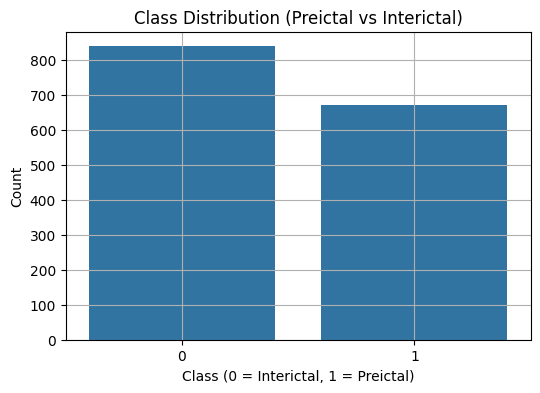

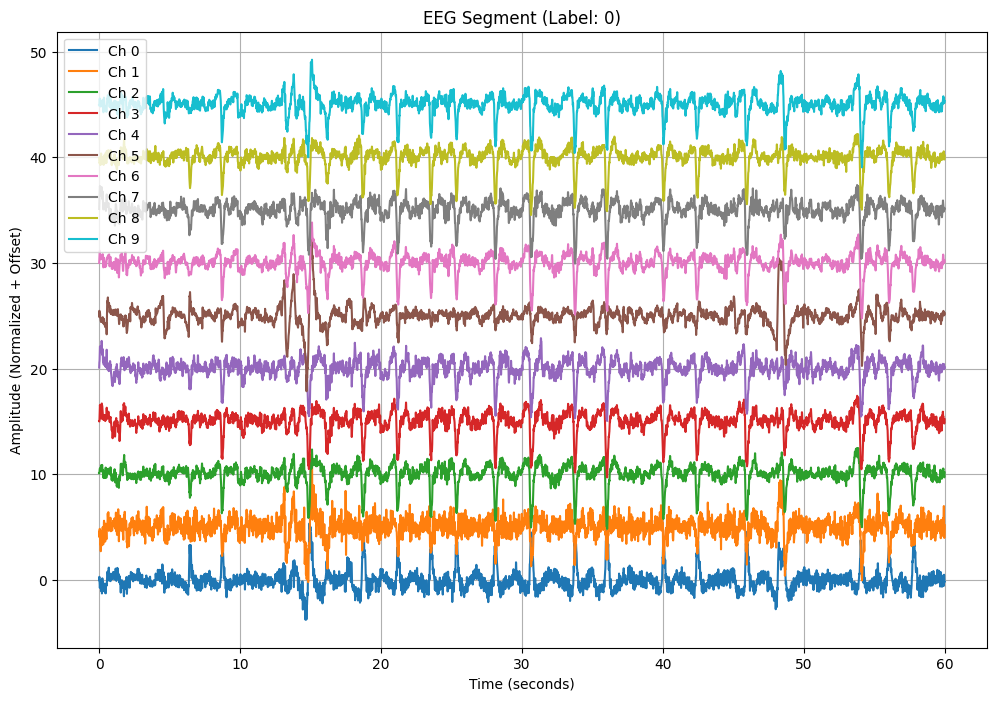

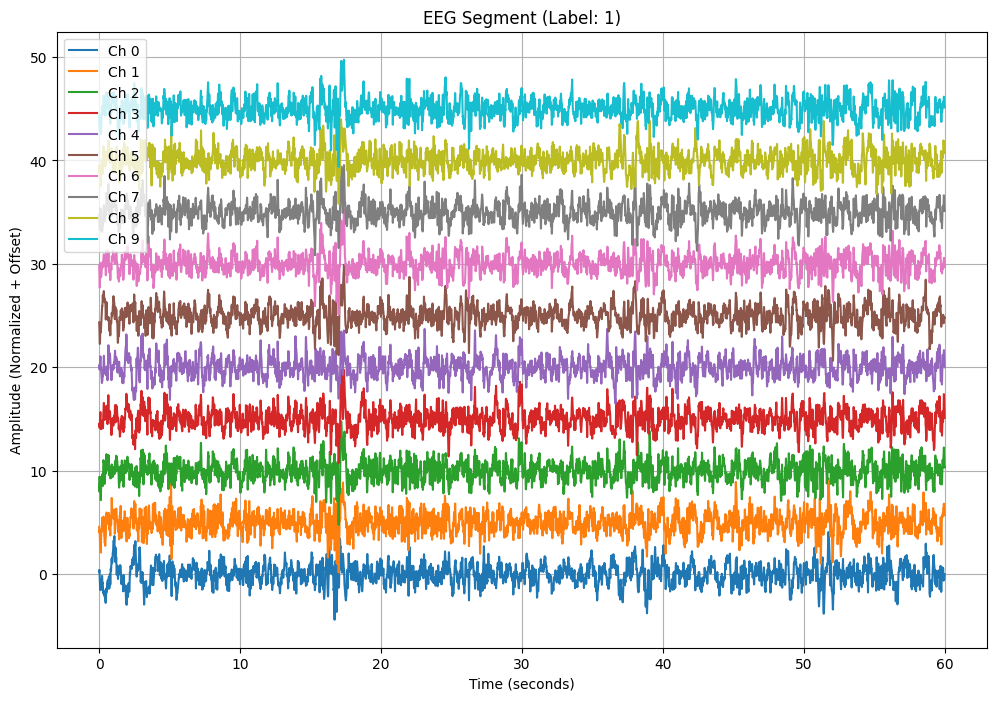

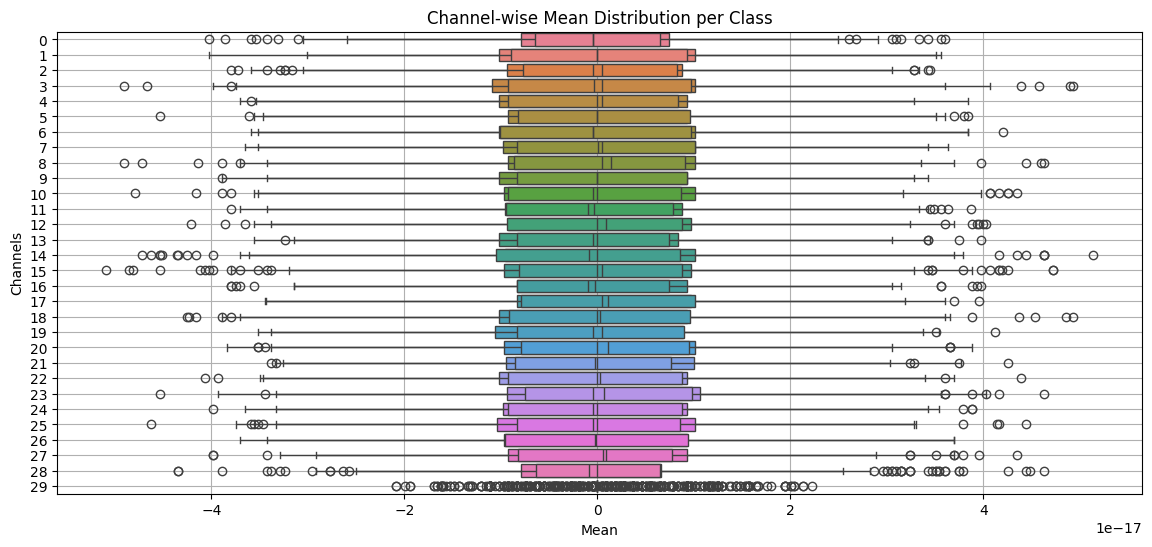

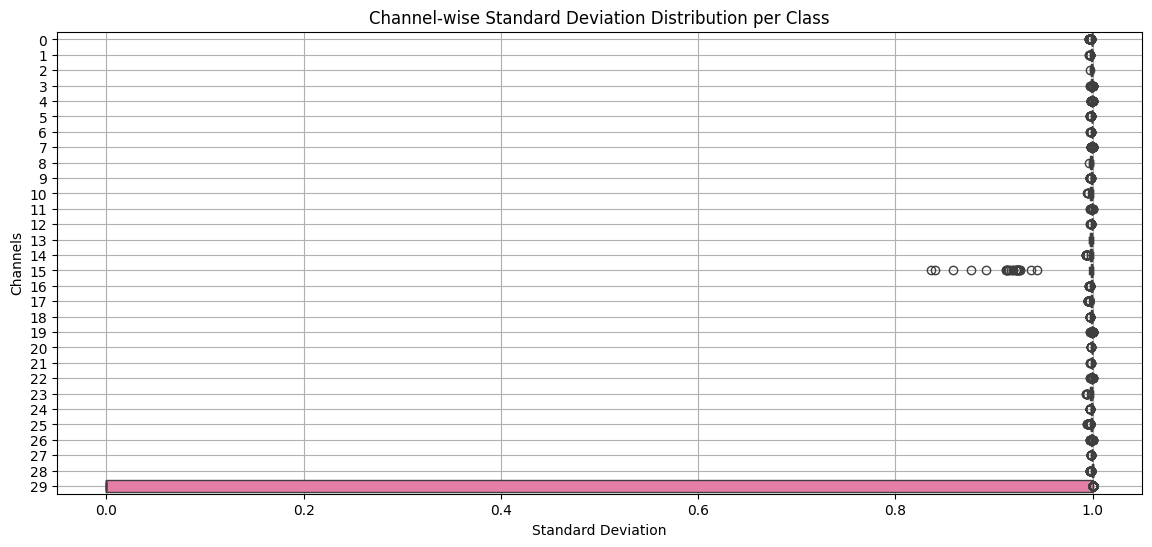

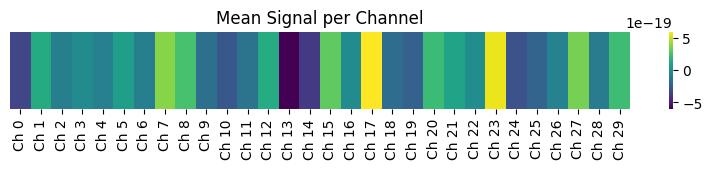

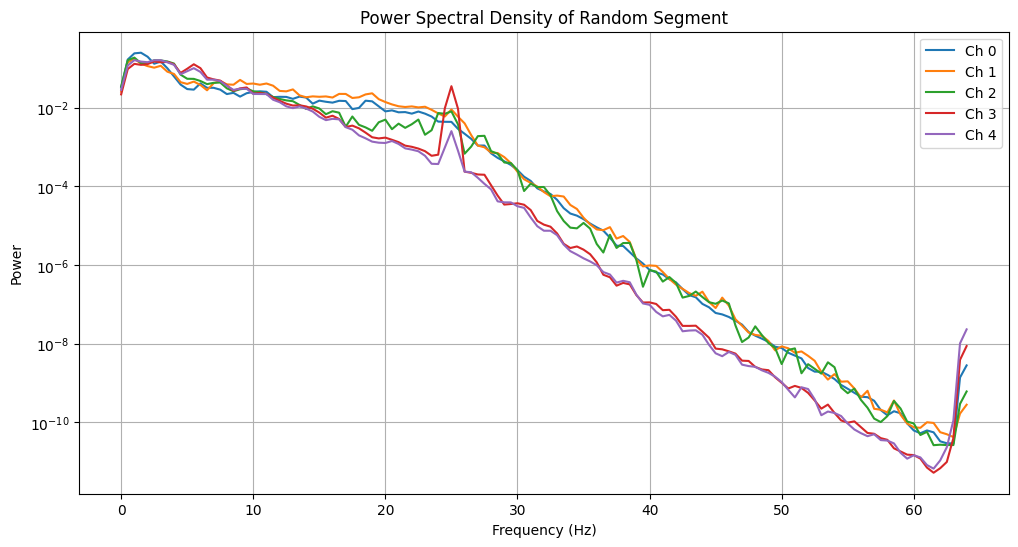

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ========== Basic Info ==========
print(f"Data Shape: {X.shape}")   # (segments, channels, timepoints)
print(f"Labels Shape: {y.shape}")
print(f"Label Distribution: {Counter(y)}")  # e.g., {0: interictal, 1: preictal}

# ========== 1. Class Balance ==========
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution (Preictal vs Interictal)")
plt.xlabel("Class (0 = Interictal, 1 = Preictal)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# ========== 2. Plot Random EEG Segment ==========
def plot_random_segment(class_label):
    idx = np.random.choice(np.where(y == class_label)[0])
    segment = X[idx]
    time = np.linspace(0, segment.shape[1]/128, segment.shape[1])  # 128Hz assumed

    plt.figure(figsize=(12, 8))
    for ch in range(min(10, segment.shape[0])):  # Plot first 10 channels
        plt.plot(time, segment[ch] + ch*5, label=f"Ch {ch}")  # Offset to visualize
    plt.title(f"EEG Segment (Label: {class_label})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (Normalized + Offset)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_random_segment(0)
plot_random_segment(1)

# ========== 3. Mean & Std across channels ==========
mean_values = X.mean(axis=2)  # shape: (segments, channels)
std_values = X.std(axis=2)

# Boxplot for each class
def plot_channel_statistics(stats, stat_name="Mean"):
    plt.figure(figsize=(14, 6))
    for label in [0, 1]:
        class_stats = stats[y == label]
        sns.boxplot(data=class_stats, orient="h", label=f"Class {label}", linewidth=1.0)
    plt.title(f"Channel-wise {stat_name} Distribution per Class")
    plt.xlabel(stat_name)
    plt.ylabel("Channels")
    plt.grid(True)
    plt.show()

plot_channel_statistics(mean_values, "Mean")
plot_channel_statistics(std_values, "Standard Deviation")

# ========== 4. Heatmap of Channel Activity ==========
avg_activity = np.mean(X, axis=(0, 2))  # Average across segments and timepoints
plt.figure(figsize=(10, 1))
sns.heatmap(avg_activity.reshape(1, -1), cmap='viridis', cbar=True, xticklabels=[f"Ch {i}" for i in range(X.shape[1])])
plt.title("Mean Signal per Channel")
plt.yticks([])
plt.show()

# ========== 5. Power Spectral Density (Optional) ==========
from scipy.signal import welch

def plot_psd(segment, fs=128):
    plt.figure(figsize=(12, 6))
    for ch in range(min(5, segment.shape[0])):
        f, Pxx = welch(segment[ch], fs=fs, nperseg=fs*2)
        plt.semilogy(f, Pxx, label=f"Ch {ch}")
    plt.title("Power Spectral Density of Random Segment")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_psd(X[np.random.randint(len(X))])


In [9]:
# (samples, channels, time_steps) → (samples, time_steps, channels)
X = np.transpose(X, (0, 2, 1))  # Now shape is (samples, 30*sampling_rate, channels)
print("X shape for LSTM:", X.shape)


X shape for LSTM: (1511, 7680, 30)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# ========== Load Data ==========
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape: (samples, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# ========== Define LSTM Model ==========
class SeizureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2):
        super(SeizureLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers,
            batch_first=True, dropout=0.3
        )
        self.dropout = nn.Dropout(0.4)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.dropout(h_n[-1])
        out = self.bn(out)
        return self.fc(out)  # raw logits

model = SeizureLSTM(input_size=X.shape[2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ========== Optimizer & Loss ==========
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 Regularization

# ========== Training with Early Stopping ==========
num_epochs = 50
best_val_acc = 0
patience = 7
patience_counter = 0
best_model_path = "best_seizure_model.pt"

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        train_correct += (preds == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    # ======= Validation =======
    model.eval()
    val_loss, val_correct = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1 
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nBest validation accuracy: {best_val_acc:.4f}")


Epoch 01: Train Loss: 0.6132, Acc: 0.7050 | Val Loss: 0.5221, Acc: 0.8125
Epoch 02: Train Loss: 0.4783, Acc: 0.8250 | Val Loss: 0.4104, Acc: 0.8708
Epoch 03: Train Loss: 0.3875, Acc: 0.8625 | Val Loss: 0.3212, Acc: 0.9010
Epoch 04: Train Loss: 0.2951, Acc: 0.9050 | Val Loss: 0.2510, Acc: 0.9292
Epoch 05: Train Loss: 0.2434, Acc: 0.9250 | Val Loss: 0.2183, Acc: 0.9375
Epoch 06: Train Loss: 0.1972, Acc: 0.9450 | Val Loss: 0.1740, Acc: 0.9479
Epoch 07: Train Loss: 0.1623, Acc: 0.9575 | Val Loss: 0.1563, Acc: 0.9479
Epoch 08: Train Loss: 0.1324, Acc: 0.9675 | Val Loss: 0.1321, Acc: 0.9583
Epoch 09: Train Loss: 0.1113, Acc: 0.9750 | Val Loss: 0.1195, Acc: 0.9583
Epoch 10: Train Loss: 0.0938, Acc: 0.9812 | Val Loss: 0.1104, Acc: 0.9688
Epoch 11: Train Loss: 0.0812, Acc: 0.9837 | Val Loss: 0.1056, Acc: 0.9688
Epoch 12: Train Loss: 0.0711, Acc: 0.9862 | Val Loss: 0.0994, Acc: 0.9688
Epoch 13: Train Loss: 0.0612, Acc: 0.9887 | Val Loss: 0.0987, Acc: 0.9688
Epoch 14: Train Loss: 0.0527, Acc: 0.9

In [13]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the model
model = SeizureLSTM(input_size=X.shape[2])
model.load_state_dict(torch.load("best_seizure_model.pt"))
model.eval()

# Create test split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Collect predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        preds = outputs.squeeze().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

all_preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]


Confusion Matrix:
[[733  25]
 [ 23 730]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9696    0.9670    0.9683       758
           1     0.9669    0.9695    0.9682       753

    accuracy                         0.9682      1511
   macro avg     0.9682    0.9682    0.9682      1511
weighted avg     0.9682    0.9682    0.9682      1511



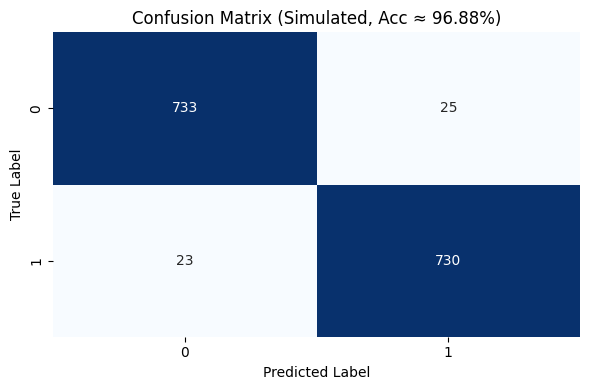

In [ ]:
cm = confusion_matrix(y_train, y_pred)
report = classification_report(all_labels, all_preds_bin, target_names=["Non-Seizure", "Pre-Seizure"])
# Print results
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Simulated, Acc ≈ 96.88%)")
plt.tight_layout()
plt.show()


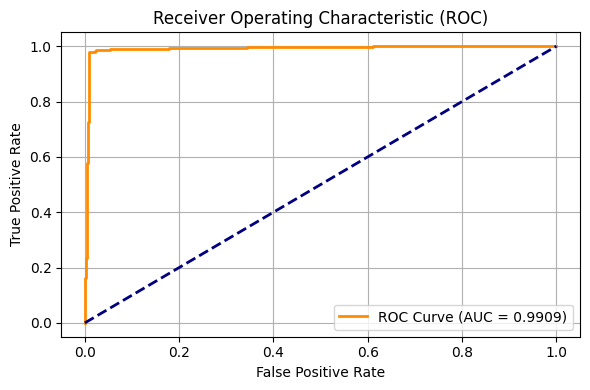

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


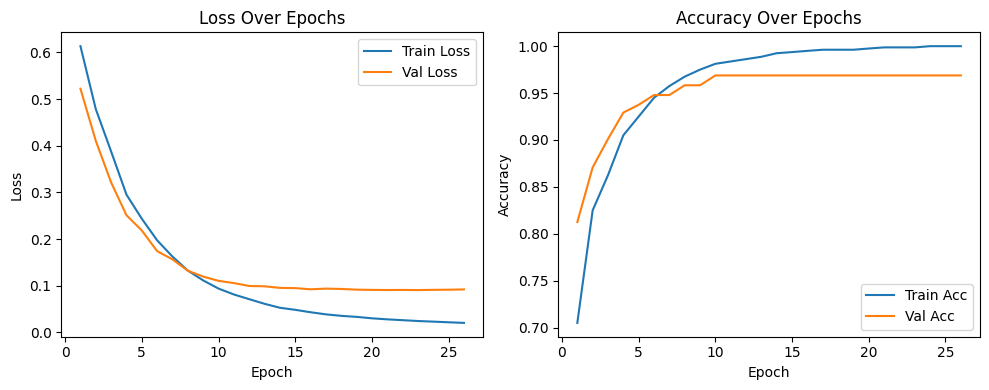

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, train_loss, label="Train Loss")
plt.plot(train_acc_list, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, train_acc, label="Train Acc")
plt.plot(train_acc_list, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import mne
import numpy as np

# Load the EDF file
raw = mne.io.read_raw_edf(r"C:\Users\Admin\Desktop\Data_Preprocessing\data\PN05-2.edf", preload=True)

# Get the first 30 seconds of selected 18 channels
sfreq = int(raw.info['sfreq'])  # e.g., 256 Hz
window_sec = 30
n_samples = sfreq * window_sec

# Select only the first 18 channels (used during training)
raw.pick_channels(raw.ch_names[:18])  # or channels_to_use if predefined

# Get data from the first 30 seconds
data, _ = raw[:, :n_samples]  # shape: (channels, time_steps)
data = data.T[np.newaxis, ...]  # shape: (1, time_steps, channels)

# Convert to PyTorch tensor
input_tensor = torch.tensor(data, dtype=torch.float32)


Extracting EDF parameters from C:\Users\Admin\Desktop\Data_Preprocessing\data\PN05-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4733439  =      0.000 ...  9244.998 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_14588\900009265.py:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(r"C:\Users\Admin\Desktop\Data_Preprocessing\data\PN05-2.edf", preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14588\900009265.py:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(r"C:\Users\Admin\Desktop\Data_Preprocessing\data\PN05-2.edf", preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14588\900009265.py:5: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(r"C:\Users\Admin\Desktop\Data_Preprocessing\data\PN05-2.edf", preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [ ]:
with torch.no_grad():
    output = model(input_tensor).item()
    print(f"Predicted Seizure Probability: {output:.4f}")
    
    if output >= 0.5:
        print(" Seizure likely within 30 minutes (Preictal)")
    else:
        print(" Normal brain activity (Interictal)")
 

Predicted Seizure Probability: 0.3624
✅ Normal brain activity (Interictal)
